# Lees Edwards boundary conditions with lbmpy

This example shows how to implement Lees Edwards boundary conditions following the principles discussed in Wagner, A.J., Pagonabarraga, I. Lees–Edwards Boundary Conditions for Lattice Boltzmann. Journal of Statistical Physics 107, 521–537 (2002). https://doi.org/10.1023/A:1014595628808

In [1]:
from lbmpy.session import *
from lbmpy.updatekernels import create_stream_pull_with_output_kernel
from lbmpy.macroscopic_value_kernels import macroscopic_values_setter
from lbmpy.maxwellian_equilibrium import get_weights
from lbmpy.relaxationrates import lattice_viscosity_from_relaxation_rate
from pystencils.astnodes import LoopOverCoordinate
from pystencils.slicing import get_periodic_boundary_functor
from functools import partial

## Parameters

In [2]:
N = 64                   # domain size
omega = 1.0             # relaxation rate of first component
U_x = 0.1                # shear velocity
shear_dir = 0            # direction of shear flow
shear_dir_normal = 1     # direction normal to shear plane, for interpolation

stencil = get_stencil("D2Q9")
weights = get_weights(stencil, c_s_sq=sp.Rational(1, 3))

## Data structures

We allocate a set of PDFs `src` and `dst`, the density field `rho` and the velocity field `u`.
For later testing, we also need a force field `F`. This will be allocated as well. 

In [3]:
dim = len(stencil[0])
dh = ps.create_data_handling((N, ) * dim,
                             periodicity=True)

src = dh.add_array('src', values_per_cell=len(stencil))
dst = dh.add_array_like('dst', 'src')
F = dh.add_array('F', values_per_cell=dh.dim)

rho = dh.add_array('rho', values_per_cell=1)
u = dh.add_array('u', values_per_cell=dh.dim)

## Kernels

Following Wagner et al., we need to find all the populations that will cross the boundary in the direction normal to the shearing direction and alter their equilibrium distribution.
Hence, we construct a piecewise function that fulfils this.

In [4]:
counters = [LoopOverCoordinate.get_loop_counter_symbol(i) for i in range(dim)]
points_up = sp.Symbol('points_up')
points_down = sp.Symbol('points_down')

U_p = sp.Piecewise((1,  sp.And(ps.data_types.type_all_numbers(counters[1] <= 1, 'int'), points_down)),
                   (-1, sp.And(ps.data_types.type_all_numbers(counters[1] >= src.shape[1] - 2, 'int'),
                               points_up)), (0, True)) * U_x

For the LB update, we will use a velocity input in the shearing direction with the magnitude `U_x` that is defined further up.

In [5]:
collision = create_lb_update_rule(stencil=stencil,
                                  relaxation_rate=omega,
                                  compressible=True,
                                  velocity_input=u.center_vector+sp.Matrix([U_p, 0]),
                                  density_input=rho,
                                  force_model='luo',
                                  force=F.center_vector,
                                  kernel_type='collide_only',
                                  optimization={'symbolic_field': src})

We need to get the populations that cross the upper and lower boundary, respectively.

In [6]:
to_insert = [s.lhs for s in collision.subexpressions
             if collision.method.first_order_equilibrium_moment_symbols[shear_dir]
             in s.free_symbols]
for s in to_insert:
    collision = collision.new_with_inserted_subexpression(s)
ma = []
for a, c in zip(collision.main_assignments, collision.method.stencil):
    if c[shear_dir_normal] == -1:
        b = (True, False)
    elif c[shear_dir_normal] == 1:
        b = (False, True)
    else:
        b = (False, False)
    a = ps.Assignment(a.lhs, a.rhs.replace(points_down, b[0]))
    a = ps.Assignment(a.lhs, a.rhs.replace(points_up, b[1]))
    ma.append(a)
collision.main_assignments = ma

In [7]:
stream = create_stream_pull_with_output_kernel(collision.method, src, dst,
                                               {'density': rho, 'velocity': u})

stream_kernel = ps.create_kernel(stream, target=dh.default_target).compile()
collision_kernel = ps.create_kernel(collision, target=dh.default_target).compile()

## Initialization

In [8]:
init = macroscopic_values_setter(collision.method, velocity=(0, 0),
                                 pdfs=src.center_vector, density=rho.center)
init_kernel = ps.create_kernel(init, ghost_layers=0).compile()

In [9]:
def init():
    dh.fill(rho.name, 1.0, ghost_layers=True)
    dh.fill(src.name, 0.0, ghost_layers=True)
    dh.fill(dst.name, 0.0, ghost_layers=True)
    dh.run_kernel(init_kernel)
    dh.fill(u.name, 0.0, ghost_layers=True)
    dh.fill(F.name, 0.0, ghost_layers=True)

## Interpolation

After applying the normal periodic boundary conditions, we interpolate back in the original cells by using a linear interpolation scheme. In this step, the corners are not special anymore so that we can use the entire upper and lower slab.

In [10]:
def get_le_boundary_functor(neighbor_stencil, shear_offset, ghost_layers=1, thickness=None):
    functor_2 = get_periodic_boundary_functor(neighbor_stencil, ghost_layers, thickness)

    def functor(pdfs, **_):

        functor_2(pdfs)
        weight = np.fmod(shear_offset[0] + N, 1.)

        # First, we interpolate the upper pdfs
        for i in range(len(pdfs[:, ghost_layers, :])):
            ind1 = int(np.floor(i - shear_offset[0]) % N)
            ind2 = int(np.ceil(i - shear_offset[0]) % N)

            res = (1 - weight) * pdfs[ind1, ghost_layers, :] + weight * pdfs[ind2, ghost_layers, :]
            pdfs[i, -ghost_layers, :] = res

        # Second, we interpolate the lower pdfs
        for i in range(len(pdfs[:, -ghost_layers, :])):
            ind1 = int(np.floor(i + shear_offset[0]) % N)
            ind2 = int(np.ceil(i + shear_offset[0]) % N)

            res = (1 - weight) * pdfs[ind1, -ghost_layers - 1, :] + weight * pdfs[ind2, -ghost_layers - 1, :]
            pdfs[i, ghost_layers - 1, :] = res

    return functor

## Timeloop

In [11]:
offset = [0.0]

sync_pdfs = dh.synchronization_function([src.name],
                                        functor=partial(get_le_boundary_functor, shear_offset=offset))

def time_loop(steps, shift):
    dh.all_to_gpu()
    for i in range(steps):
        dh.run_kernel(collision_kernel)

        sync_pdfs()
        dh.run_kernel(stream_kernel)

        dh.swap(src.name, dst.name)
        shift[0] += U_x
    dh.all_to_cpu()

In [12]:
def plot_v():
    plt.subplot(121)
    plt.title("$v_A$")
    plt.vector_field(dh.gather_array(u.name), step=2)
    plt.subplot(122)
    plt.vector_field_magnitude(dh.gather_array(u.name))
    plt.colorbar()

## Run the simulation
### Initialize all velocities with zero

In [13]:
init()

### Run the simulation to show the flow profile

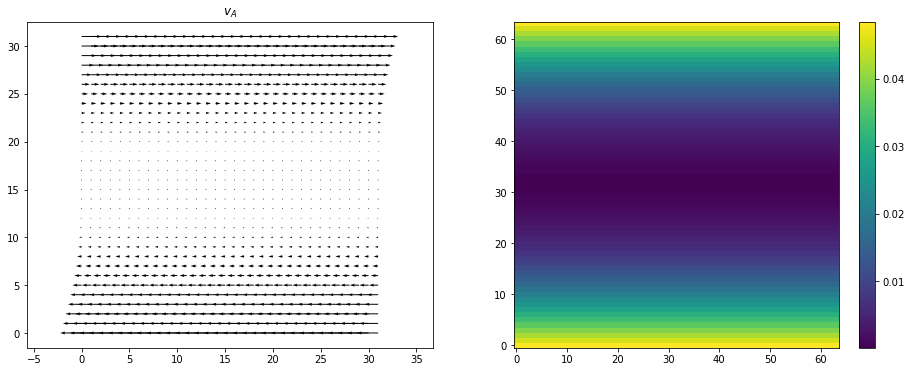

In [14]:
time = 500
time_loop(time, offset)

plot_v()

## Checking the results

This transient shear flow (planar Couette flow) can be modeled with the Navier Stokes equation. We use this as a testcase here.

The solution of the Navier Stokes equation in this particular case yields:

$ w(x,t) = v \left[ \frac{x}{h} - \frac{1}{2} + \sum_{k=1} ^\infty \frac{1}{\pi k} e^{-\frac{4 \pi^2 \nu k^2}{h^2} t} \sin \left( \frac{2 \pi}{h} kx \right) \right] $

with $w$ as the resulting velocity, $v$ as shear velocity, $h$ as the height, $\nu$ as kinematic viscosity and $t$ as time.

In [15]:
def get_solution_navier_stokes(x, t, viskosity, velocity=1.0, height=1.0, max_iterations=10):
    w = x / height - 0.5
    for k in np.arange(1, max_iterations + 1):
        w += 1.0 / (np.pi * k) * \
            np.exp(-4 * np.pi**2 * viskosity * k**2 / height**2 * t) * \
            np.sin(2 * np.pi / height * k * x)
    return velocity * w

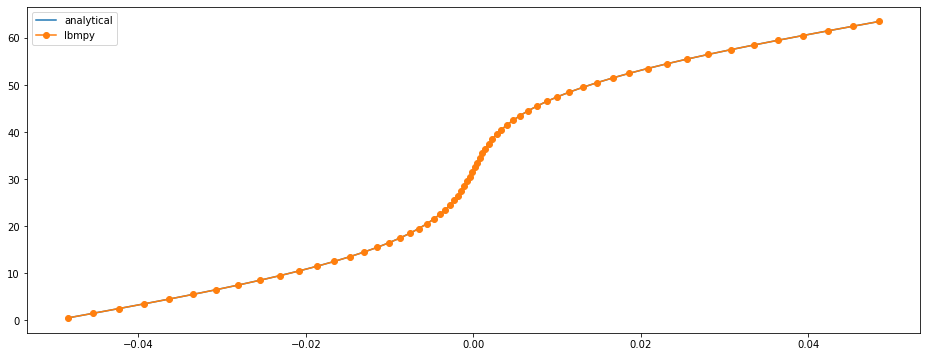

In [16]:
nu = lattice_viscosity_from_relaxation_rate(omega)
h = N
k_max = 100

X = np.linspace(0.5, h-0.5, h)
U = get_solution_navier_stokes(X, time, nu, U_x, h, k_max)
plt.plot(U, X, label='analytical')

X_lb = np.linspace(0.5, h-0.5, h)
U_lb = dh.gather_array(u.name)[0, :, 0]

plt.plot(U_lb, X_lb, 'o-', label='lbmpy')
plt.legend()

## Testing of the interpolation scheme

We redefine our init function here. In order to test the interpolation scheme, we send an impulse across the boundary in the shear gradient direction. If interpolated correctly, it should appear shifted to the right by the preselected offset. Therefore we also need to fix the offset and redefine the time loop.

In [17]:
def time_loop_2(steps):
    dh.all_to_gpu()
    for i in range(steps):
        dh.run_kernel(collision_kernel)

        sync_pdfs()
        dh.run_kernel(stream_kernel)

        dh.swap(src.name, dst.name)
    dh.all_to_cpu()


def init_2():
    dh.fill(rho.name, 1.0, ghost_layers=True)
    dh.fill(src.name, 0.0, ghost_layers=True)
    dh.fill(dst.name, 0.0, ghost_layers=True)
    dh.run_kernel(init_kernel)
    dh.fill(u.name, 0.0, ghost_layers=True)
    dh.fill(F.name, 0.0, ghost_layers=True)
    dh.cpu_arrays[F.name][N//3, 1, :] = [1e-2, -1e-1]

## Run the simulation without any offset and a constant offset

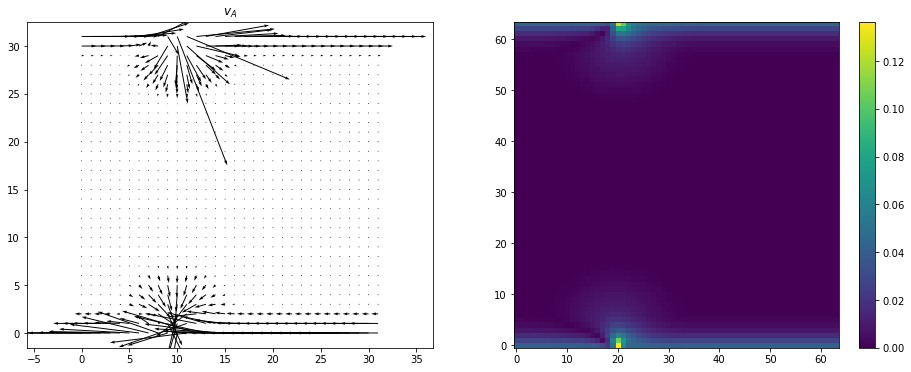

In [18]:
offset[0] = 0

init_2()
time = 20
time_loop_2(time)
plot_v()

vel_unshifted = np.array(dh.gather_array(u.name)[:, -3:-1, :])

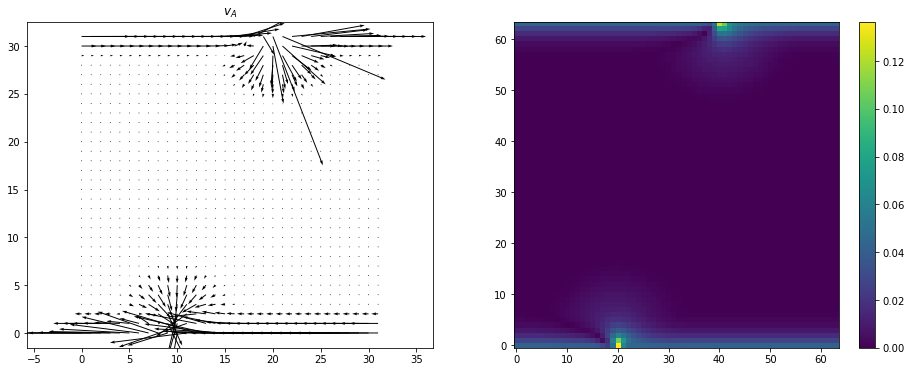

In [19]:
offset[0] = 20

init_2()
time = 20
time_loop_2(time)
plot_v()

vel_shifted = np.array(dh.gather_array(u.name)[:, -3:-1, :])

### We role the array back by the offset and compare it to the results of the unshifted measurement

In [20]:
vel_rolled = np.roll(vel_shifted, -offset[0], axis=0)

### Finally let's run the simualtion with fixed offset a while longer

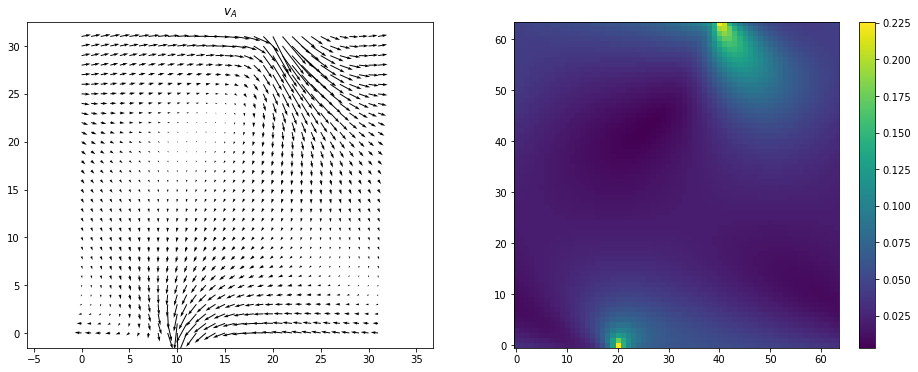

In [21]:
init_2()
time = 500
time_loop_2(time)
plot_v()